In [14]:
import sys
sys.path.append('../code') 
import mocap_functions
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from sklearn.model_selection import ShuffleSplit
import scipy.io as sio
import multiprocessing
num_cores = multiprocessing.cpu_count()


In [2]:
data_path = '../data/SPK20220308/task_data/'
kinematic_df, neural_df, metadata = mocap_functions.load_mocap_df(data_path)
video_df = pd.read_pickle(data_path + 'video_df.pkl')


num_trials = metadata['num_trials']

#Generate cv_dict for regular train/test/validate split (no rolling window)
cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)
cv_dict = {}
for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(np.arange(num_trials))):
    for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
        cv_dict[fold] = {'train_idx':train_val_idx[t_idx], 
                         'test_idx':test_idx, 
                         'validation_idx':train_val_idx[v_idx]} 

In [12]:
# Filter dataframes add or remove layout info
nolayout_neural_mask = ~(neural_df['unit'].str.contains(pat='layout'))
noposition_neural_mask = ~(neural_df['unit'].str.contains(pat='position'))
neural_df = neural_df[np.logical_and(nolayout_neural_mask, noposition_neural_mask)]

In [3]:
reader = torchvision.io.VideoReader('../data/SPK20220308/videos/SpikeCam1_03-08-1557.mp4', 'video')

In [4]:
analog_sampling_rate = 1000
cam_frames = np.load('cam_frames.npy')

fpath = '../data/SPK20220308/task_data/'
experiment_dict = sio.loadmat(f'{fpath}eventsCB1_corrected.mat')
ev_ex = experiment_dict['eventsCB1']

cam_start = cam_frames[0] / analog_sampling_rate

In [5]:
for idx in range(60):
    print(idx, end=' ')
    reader.seek(video_df['frames'][0][idx] - cam_start)
    frame = next(reader)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(frame['data'].numpy()[0,:,:])

    plt.subplot(1,2,2)
    pooler = torch.nn.AvgPool2d(kernel_size=100, stride=50)
    frame_pooled = pooler(frame['data'].float())
    plt.imshow(frame_pooled[0,:,:])

    plt.savefig(f'../data/SPK20220308/frames/frame{idx}.png')
    plt.close()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 

In [6]:
images = [f'frame{idx}.png' for idx in range(60)]
mocap_functions.make_movie('../data/SPK20220308/frames/', 'pooling_layer.mp4', images, fps=30, quality=10)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1000, 500) to (1008, 512) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [70]:
# Dataset class to handle mocap dataframes from SEE project
class SEE_Video_Dataset(torch.utils.data.Dataset):
    #'Characterizes a dataset for PyTorch'
    def __init__(self, cv_dict, fold, partition, video_df, neural_df, reader,
                 offset, window_size, data_step_size, device, cam_start,
                 scale_neural=True, flip_outputs=False, scaler=None):
        #'Initialization'
        self.cv_dict = cv_dict
        self.fold = fold
        self.flip_outputs = flip_outputs
        self.partition = partition
        self.trial_idx = cv_dict[fold][partition]
        self.num_trials = len(self.trial_idx) 
        self.offset = offset
        self.window_size = window_size
        self.data_step_size = data_step_size
        self.device = device
        self.videoData_list, self.neuralData_list = self.process_dfs(video_df, neural_df)
        self.pooler = torch.nn.AvgPool2d(kernel_size=100, stride=50)
        self.reader = reader
        self.cam_start = cam_start

        if scaler is None:
            self.scaler = StandardScaler()
        else:
            self.scaler = scaler
        
        if scale_neural:
            self.neuralData_list = self.transform_data(self.neuralData_list)

        self.split_offset = np.round((self.offset/self.data_step_size) / 2).astype(int)

        self.X_tensor, self.y_tensor = self.load_splits()
        self.num_samples = np.sum(self.X_tensor.size(0))

    def __len__(self):
        #'Denotes the total number of samples'
        return self.num_samples

    # Need to modify if flipouts is ever enabled
    def __getitem__(self, slice_index):
        frame_data = list()
        frame_times = self.X_tensor[slice_index, :, :]
        for ftime in frame_times:
            self.reader.seek(ftime - self.cam_start)
            frame = next(self.reader)
            frame_pooled = self.pooler(frame['data'].float())
            frame_data.append(frame_pooled)

        return frame_data, self.y_tensor[slice_index,:,:]

    def process_dfs(self, video_df, neural_df):
        frame_list, neuralData_list = list(), list()
        for trial in self.trial_idx:
            frame_array = np.stack(video_df['frames'][video_df['trial'] == trial].values).transpose() 
            neuralData_array = np.stack(neural_df['rates_video'][neural_df['trial'] == trial].values).squeeze().transpose() 

            frame_list.append(frame_array)
            neuralData_list.append(neuralData_array)

        return frame_list, neuralData_list

    # **START HERE**, need to check if frame list is the right shape for unfold
    # Hold of torchvision reader seek until end, but should still be able to unfold frame times
    def format_splits(self, data_list):
        unfolded_data_list = list()
        for trial_idx in range(self.num_trials):
            unfolded_trial = torch.from_numpy(data_list[trial_idx]).unfold(0, self.window_size, self.data_step_size).transpose(1, 2)
            unfolded_data_list.append(unfolded_trial)
        
        data_tensor = torch.concat(unfolded_data_list, axis=0)

        return data_tensor
    
    def load_splits(self):
        if not self.flip_outputs:
            X_tensor = self.format_splits(self.videoData_list)
            y_tensor = self.format_splits(self.neuralData_list)
        else:
            y_tensor = self.format_splits(self.videoData_list)
            X_tensor = self.format_splits(self.neuralData_list)

        X_tensor, y_tensor = X_tensor[:-self.split_offset,::self.data_step_size,:], y_tensor[self.split_offset:,::self.data_step_size,:]

        assert X_tensor.shape[0] == y_tensor.shape[0]
        return X_tensor, y_tensor

    #Zero mean and unit std
    def transform_data(self, data_list):
        #Iterate over trials and apply normalization
     
        scaled_data_list = []
        for data_trial in data_list:
            scaled_data_trial = self.scaler.fit_transform(data_trial)
            scaled_data_list.append(scaled_data_trial)

        return scaled_data_list

In [71]:
# Set up PyTorch Dataloaders
fold=0
scale_neural = True
flip_outputs = False
device = 'cpu'

offset = 2
window_size = 1
data_step_size = 1
# Parameters
batch_size = 10000
train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}

In [72]:
training_set = SEE_Video_Dataset(cv_dict=cv_dict, fold=fold, partition='train_idx', video_df=video_df,
                           neural_df=neural_df, reader=reader, offset=offset, window_size=window_size,
                           data_step_size=data_step_size, device=device, cam_start=cam_start,
                           scale_neural=scale_neural, flip_outputs=flip_outputs, scaler=None)

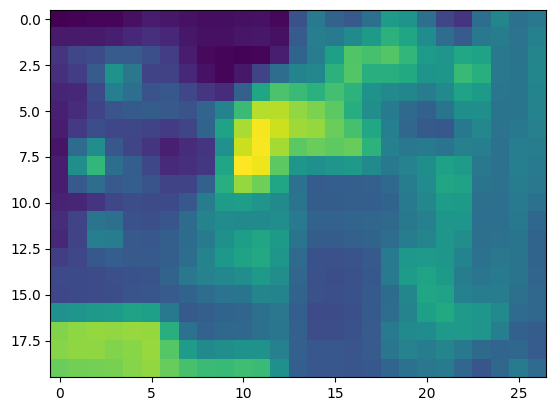

In [77]:
plt.imshow(training_set[0][0][0][0,:,:].numpy())

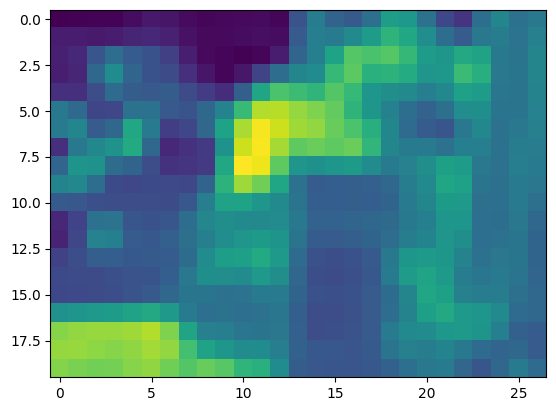

In [79]:
plt.imshow(training_set[1000][0][0][0,:,:].numpy())